# Mathematical Foundations on Deep Neural Network
## Homework #8
### 2017-11362 박건도

## Problem 1.

In [1]:
import torch
import torch.utils.data as data 
import torch.nn as nn
from torch.distributions.normal import Normal 
from torch.distributions.uniform import Uniform
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

epochs = 500
learning_rate = 5e-3
batch_size = 128
n_components = 5 # the number of kernel
target_distribution = Normal(0.0, 1.0)

In [2]:
#####################################
# STEP 1: Implement 1-d Flow model  #
# Model is mixture of Gaussian CDFs #
#####################################

class Flow1d(nn.Module):
    def __init__(self, n_components):
        super(Flow1d, self).__init__()
        self.mus = nn.Parameter(torch.randn(n_components), requires_grad=True)
        self.log_sigmas = nn.Parameter(torch.zeros(n_components), requires_grad=True)
        self.weight_logs = nn.Parameter(torch.zeros(n_components), requires_grad=True)

    def forward(self, x):
        x = x.view(-1,1)
        weights = self.weight_logs.exp().view(1,-1)
        distribution = Normal(self.mus, self.log_sigmas.exp())
        z = (weights * (distribution.cdf(x) - 0.5)).sum(dim=1)
        dz_by_dx = (distribution.log_prob(x).exp() * weights).sum(dim=1)
        return z, dz_by_dx

In [3]:
################################################
# STEP 2: Create Dataset and Create Dataloader #
################################################ 

def mixture_of_gaussians(num, mu_var=(-1,0.25, 0.2,0.25, 1.5,0.25)):
    n = num // 3
    m1,s1,m2,s2,m3,s3 = mu_var
    gaussian1 = np.random.normal(loc=m1, scale=s1, size=(n,))
    gaussian2 = np.random.normal(loc=m2, scale=s2, size=(n,))
    gaussian3 = np.random.normal(loc=m3, scale=s3, size=(num-n,))
    return np.concatenate([gaussian1, gaussian2, gaussian3])

class MyDataset(data.Dataset):
    def __init__(self, array):
        super().__init__()
        self.array = array

    def __len__(self):
        return len(self.array)

    def __getitem__(self, index):
        return self.array[index]

In [4]:
################################
# STEP 3: Define Loss Function #
################################

def loss_function(target_distribution, z, dz_by_dx):
    # log(p_Z(z)) = target_distribution.log_prob(z)
    # log(dz/dx) = dz_by_dx.log() (flow is defined so that dz/dx>0)
    log_likelihood = target_distribution.log_prob(z) + dz_by_dx.log()
    return -log_likelihood.mean()  #flip sign, and sum of data X_1,...X_N

In [5]:
###########################
# STEP 4: Train the model #
########################### 

# create dataloader
n_train, n_test = 5000, 1000
train_data = mixture_of_gaussians(n_train)
test_data = mixture_of_gaussians(n_test)

train_loader = data.DataLoader(MyDataset(train_data), batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(MyDataset(test_data), batch_size=batch_size, shuffle=True)

# create model
flow = Flow1d(n_components)
optimizer = torch.optim.Adam(flow.parameters(), lr=learning_rate)

train_losses, test_losses = [], []

for epoch in range(epochs):
    # train
    # flow.train()
    mean_loss = 0
    for i, x in enumerate(train_loader):
        z, dz_by_dx = flow(x)
        loss = loss_function(target_distribution, z, dz_by_dx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mean_loss += loss.item()
    train_losses.append(mean_loss/(i+1))

    # test
    flow.eval()
    mean_loss = 0
    for i, x in enumerate(test_loader):
        z, dz_by_dx = flow(x)
        loss = loss_function(target_distribution, z, dz_by_dx)

        mean_loss += loss.item()
    test_losses.append(mean_loss/(i+1))

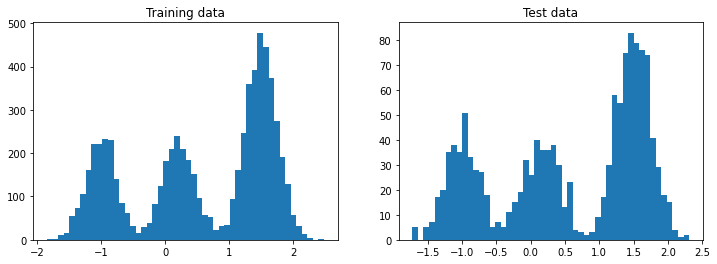

In [6]:
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].hist(train_loader.dataset.array, bins=50)
_ = axes[1].hist(test_loader.dataset.array, bins=50)
_ = axes[0].set_title('Training data')
_ = axes[1].set_title('Test data')

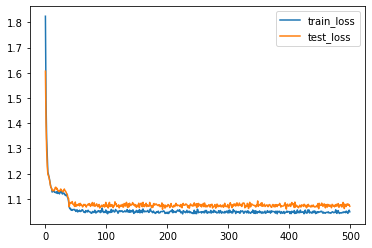

In [7]:
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.legend()

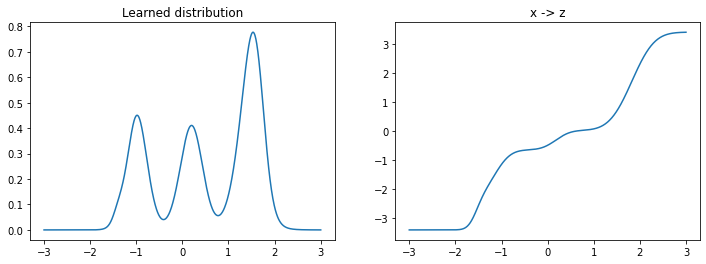

In [8]:
x = np.linspace(-3,3,1000)
with torch.no_grad():
    z, dz_by_dx = flow(torch.FloatTensor(x))
    px = (target_distribution.log_prob(z) + dz_by_dx.log()).exp().cpu().numpy()
    
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].plot(x,px)
_ = axes[0].set_title('Learned distribution')

_ = axes[1].plot(x,z)
_ = axes[1].set_title('x -> z')

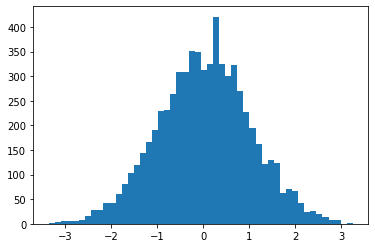

In [9]:
with torch.no_grad():
    z, _ = flow(torch.FloatTensor(train_loader.dataset.array))
    
_ = plt.hist(np.array(z), bins=50)

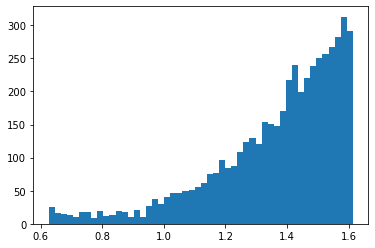

In [10]:
# sampling
N = 5000
z = torch.rand(N)
x_low = torch.full((N,), -3.)
x_high = torch.full((N,), 3.)

#Perform bisection
with torch.no_grad():
    for _ in range(30):
        m = (x_low+x_high)/2
        f,_ = flow(m)
        x_high[f>=z] = m[f>=z]
        x_low[f<z] = m[f<z]
    x = (x_low+x_high)/2

_ = plt.hist(np.array(x), bins=50)

## Problem 2.

![prob2.png](prob2.png)

## Problem 3.

In [11]:
def inv_perm(perm):
    ans = [0] * len(perm)
    for (n, i) in enumerate(perm):
        ans[i - 1] = n + 1
    return ans

perm = [1,4,6,5,3,2]
print(inv_perm(perm))
for i in range(1, 7):
    print(f'p({i}) = {perm[i-1]}, p^-1(p({i})) = p^-1({perm[i-1]}) = {inv_perm(perm)[perm[i-1]-1]}')

[1, 6, 5, 2, 4, 3]
p(1) = 1, p^-1(p(1)) = p^-1(1) = 1
p(2) = 4, p^-1(p(2)) = p^-1(4) = 2
p(3) = 6, p^-1(p(3)) = p^-1(6) = 3
p(4) = 5, p^-1(p(4)) = p^-1(5) = 4
p(5) = 3, p^-1(p(5)) = p^-1(3) = 5
p(6) = 2, p^-1(p(6)) = p^-1(2) = 6


## Problem 4.

![prob4](prob4.png)

## Problem 5.

![prob5](prob5.png)

## Problem 6.

In [12]:
N = 3000
K = 600
p, q = 18/37, 0.55
def B_samp(n, p):
    return (torch.rand(n) < p).numpy()

def f_over_g(x, p, q):
    x_sum = np.sum(x)
    return np.exp(x_sum * np.log(p/q) + (len(x) - x_sum) * np.log((1-p)/(1-q)))

def win(x):
    cumsum = 100
    for i in range(len(x)):
        cumsum += 2 * x[i] - 1
        if cumsum <= 0:
            return 0, i + 1
        elif cumsum >= 200:
            return 1, i + 1
    return 0, i + 1

total = 0
for _ in range(N):
    x = B_samp(K, q)
    prob, ind = win(x)
    imp_samp = prob * f_over_g(x, p, q)
    total += imp_samp

print(total / N)

2.519068918962955e-06


## Problem 7.

#### (a) the log-derivative trick

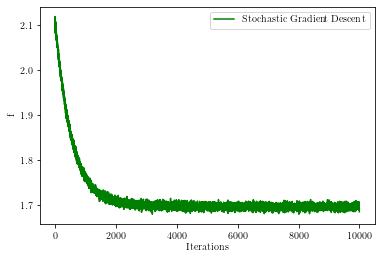

mu: 0.44403578860227777, sigma: 0.6089689065449186


In [13]:
alpha = 5e-4
theta = np.zeros(2) # (mu, tau), exp(tau) = sigma
def f(theta):
    x = np.exp(theta[1]) * np.random.randn(10000) + theta[0]
    E = np.sum(x * np.sin(x)) / 10000
    return E + 0.5 * (theta[0] - 1) ** 2 + np.exp(theta[1]) - theta[1]

def grad(theta):
    mu, sigma = theta[0], np.exp(theta[1])
    x = sigma * np.random.randn(10000) + mu
    grad_mu = np.sum((x - mu) / sigma ** 2 * x * np.sin(x)) / 10000 + mu - 1
    grad_tau = np.sum(((x - mu) ** 2 / sigma ** 2 - 1) * x * np.sin(x)) / 10000 + sigma - 1
    return np.array([grad_mu, grad_tau])

f_val = []
K = 10000
for _ in range(K):
    theta = theta - alpha * grad(theta)
    f_val.append(f(theta))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(list(range(K)),f_val, color = "green", label = "Stochastic Gradient Descent")
plt.xlabel('Iterations')
plt.ylabel('f')
plt.legend()
plt.show()
print(f'mu: {theta[0]}, sigma: {np.exp(theta[1])}')

#### (b) the reparameterization trick

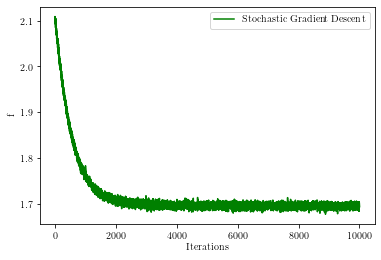

mu: 0.44390201993186706, sigma: 0.6087760410307997


In [14]:
alpha = 5e-4
theta = np.zeros(2) # (mu, tau), exp(tau) = sigma
def f(theta):
    x = np.exp(theta[1]) * np.random.randn(10000) + theta[0]
    E = np.sum(x * np.sin(x)) / 10000
    return E + 0.5 * (theta[0] - 1) ** 2 + np.exp(theta[1]) - theta[1]

def grad(theta):
    mu, sigma = theta[0], np.exp(theta[1])
    eps = np.random.randn(10000)
    x = sigma * eps + mu
    grad_mu = np.sum(np.sin(x) + x * np.cos(x)) / 10000 + mu - 1
    grad_tau = np.sum(sigma * eps * (np.sin(x) + x * np.cos(x))) / 10000 + sigma - 1
    return np.array([grad_mu, grad_tau])

f_val = []
K = 10000
for _ in range(K):
    theta = theta - alpha * grad(theta)
    f_val.append(f(theta))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(list(range(K)),f_val, color = "green", label = "Stochastic Gradient Descent")
plt.xlabel('Iterations')
plt.ylabel('f')
plt.legend()
plt.show()
print(f'mu: {theta[0]}, sigma: {np.exp(theta[1])}')

## Problem 8.

![prob8](prob8.png)